In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import fdb
import loompy
import shoji
from tqdm import trange
import logging
import sys
from rich.progress import track
%load_ext line_profiler
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=20)

In [2]:
db = shoji.connect()
db

,Contents
refdb,"1 workspaces, 0 dimensions, 0 tensors"
scRNA,"0 workspaces, 2 dimensions, 4 tensors"


In [3]:
if "test" in db:
    del db.test
db.test = shoji.Workspace()
db.test.cells = shoji.Dimension(shape=None)
db.test.Jagged = shoji.Tensor("uint16", ("cells", None, 10, None), [np.random.randint(0, 50, size=(x,10, x), dtype="uint16") for x in range(100)])
db.test.Age = shoji.Tensor("int32", ("cells",), np.arange(100, dtype="int32"))
db.test.Description = shoji.Tensor("string", (), "Hello")
#db.test.Age = shoji.Tensor("string", ("cells",), np.array(["Hej", "då"]*10000, dtype=object))
#data = np.random.randint(0, 50, size=(20000,100), dtype="int32")
#db.test.Shoes = shoji.Tensor("int32", ("cells",None), data[:20000])

In [4]:
ws = db.test
#ws[ws.cells[:10] & (ws.Age == "Hej")].Age
ws[ws.cells[:10] & (ws.Age < 5)].Jagged

[array([], shape=(0, 10, 0), dtype=uint16), array([[[ 6],
         [14],
         [28],
         [29],
         [33],
         [42],
         [ 2],
         [ 5],
         [21],
         [44]]], dtype=uint16), array([[[20, 48],
         [39, 45],
         [43, 13],
         [31, 22],
         [ 9, 23],
         [21, 46],
         [40, 45],
         [ 0,  8],
         [31,  3],
         [48,  8]],
 
        [[27,  6],
         [18, 12],
         [ 6, 18],
         [48, 34],
         [36, 25],
         [ 5, 16],
         [40, 27],
         [14, 26],
         [32, 27],
         [ 2, 32]]], dtype=uint16), array([[[34, 37, 26],
         [17, 13,  6],
         [33, 43, 48],
         [ 6, 28, 43],
         [21, 48, 42],
         [10,  1, 42],
         [11,  5, 12],
         [13, 37, 49],
         [41, 45, 26],
         [49, 16, 31]],
 
        [[46,  0, 32],
         [26, 14, 23],
         [19, 27, 10],
         [ 4, 39, 17],
         [48,  8, 29],
         [49, 31, 13],
         [22,  9, 48]

In [5]:
if "scRNA" in db:
    del db.scRNA
if "images" in db:
    del db.images
if "mouse" in db:
    del db.mouse

In [6]:
db.images = shoji.Workspace()
db.images.cells = shoji.Dimension(shape=None)
db.images.Images = shoji.Tensor("uint16", ("cells", 2000, 2000))

In [9]:
db.images.cells.append({
    "Images": np.random.randint(0, 50, size=(1, 2000, 2000), dtype="uint16")
})

In [10]:
%%time
db.images

CPU times: user 1.83 ms, sys: 1.44 ms, total: 3.27 ms
Wall time: 3.23 ms


Workspace with 0 subspaces, 1 dimensions and 1 tensors:
  cells <Dimension of variable shape>
  Images <Tensor dtype='uint16' dims=('cells', 2000, 2000), shape=(3, 0, 0)>

In [11]:
del db.scRNA
db.scRNA = shoji.Workspace()
db.scRNA.cells = shoji.Dimension(shape=None)
db.scRNA.genes = shoji.Dimension(shape=5000)
db.scRNA.Expression = shoji.Tensor("int16", ("cells", "genes"))
db.scRNA.CellType = shoji.Tensor("string", ("cells",))
db.scRNA.Length = shoji.Tensor("uint16", ("genes",))
db.scRNA.Chromosome = shoji.Tensor("string", ("genes",))

In [15]:
ws = db.scRNA
ws.cells.append({
	"CellType": np.array(["Neuron", "Astrocyte", "Neuron", "Miroglia"], dtype=object),
	"Expression": np.random.randint(0, 10, size=(4, 5000), dtype="uint16")
})


In [5]:
%%time
db.scRNA.cells.append({
    "Spliced": np.random.randint(0, 10, size=(20000, 5000), dtype="int16"),
    "Age": np.random.randint(0, 50, size=20000, dtype="uint16")
})

CPU times: user 3.83 s, sys: 340 ms, total: 4.17 s
Wall time: 6.87 s


In [6]:
%%time
db.scRNA[::20].Spliced.shape

CPU times: user 1.1 s, sys: 224 ms, total: 1.32 s
Wall time: 1.8 s


(21000, 5000)

In [7]:
v = db.scRNA[db.scRNA.cells[:1000] - (db.scRNA.Age > 10), db.scRNA.Length > 40]
v.Spliced.shape
#v.Age.shape

(182, 994)

In [3]:
fpool = "/Users/stelin/cytograph/20191003/data/dev_all.loom"
fagg = "/Users/stelin/cytograph/20191003/data/dev_all.agg.loom"

if "mouse" not in db:
    db.mouse = shoji.Workspace()

def from_loom(ws: shoji.WorkspaceManager, f: str, layers: List[str] = None) -> None:
    with loompy.connect(f, validate=False) as ds:
        if layers is None:
            layers = list(ds.layers.keys())
        ws.genes = shoji.Dimension(shape=None)
        ws.cells = shoji.Dimension(shape=None)

        STEP = 2000
        logging.info("Loading row attributes")
        for i in trange(0, ds.shape[0], STEP):
            d = {}
            for key, vals in ds.ra.items():
                dtype = vals.dtype.name
                name = key[0].upper() + key[1:]
                d[name] = ds.ra[key][i:i + STEP]
                if i == 0:
                    dims = ("genes", ) + (None,) * (vals.ndim - 1)
                    ws[name] = shoji.Tensor("string" if dtype == "object" else dtype, dims=dims)
            ws.genes.append(d)

        ws.genes = shoji.Dimension(shape=ds.shape[0])  # Set to a fixed shape to avoid jagged arrays below
        
        skipped = [x for x in ds.ca.keys() if x in ds.ra.keys()]
        for key, vals in ds.ca.items():
            dtype = ds.ca[key].dtype.name
            name = key[0].upper() + key[1:]
            dims = ("cells", ) + (None,) * (vals.ndim - 1)
            if name in skipped:
                logging.warning(f"Column attribute '{name}' skipped because a row attribute already exists with that name.")
                skipped.append(name)
            else:
                ws[name] = shoji.Tensor("string" if dtype == "object" else dtype, dims=dims)

        logging.info("Loading column attributes and matrix layers")
        STEP = 200
        for i in trange(0, ds.shape[1], STEP):
            d = {}
            for key in ds.ca.keys():
                name = key[0].upper() + key[1:]
                if name in skipped:
                    continue
                d[name] = ds.ca[key][i:i + STEP]
            for key in layers:
                if key not in ds.layers:
                    raise KeyError(f"Layer '{key}' not found")
                if key == "":
                    name = "Expression"
                else:
                    name = key[0].upper() + key[1:]
                dtype = ds.layers[key].dtype.name
                if i == 0:
                    ws[name] = shoji.Tensor("string" if dtype == "object" else dtype, ("cells", "genes"))
                d[name] = ds.layers[key][:, i:i + STEP].T
            ws.cells.append(d)

if "mouse" in db:
    del db.mouse
    db.mouse = shoji.Workspace()
    db.mouse.Development = shoji.Workspace()

from_loom(db.mouse.Development, fpool, layers=["spliced", "unspliced"])

2020-07-17 09:04:47,211 - INFO - Loading row attributes


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


2020-07-17 09:05:06,537 - WARNING - Column attribute 'HPF' skipped because a row attribute already exists with that name.
2020-07-17 09:05:11,216 - INFO - Loading column attributes and matrix layers


100%|██████████| 1463/1463 [54:41<00:00,  2.24s/it] 


(-93.47135612473735, 77.1371292856651, -88.76275844115655, 70.28421518344678)

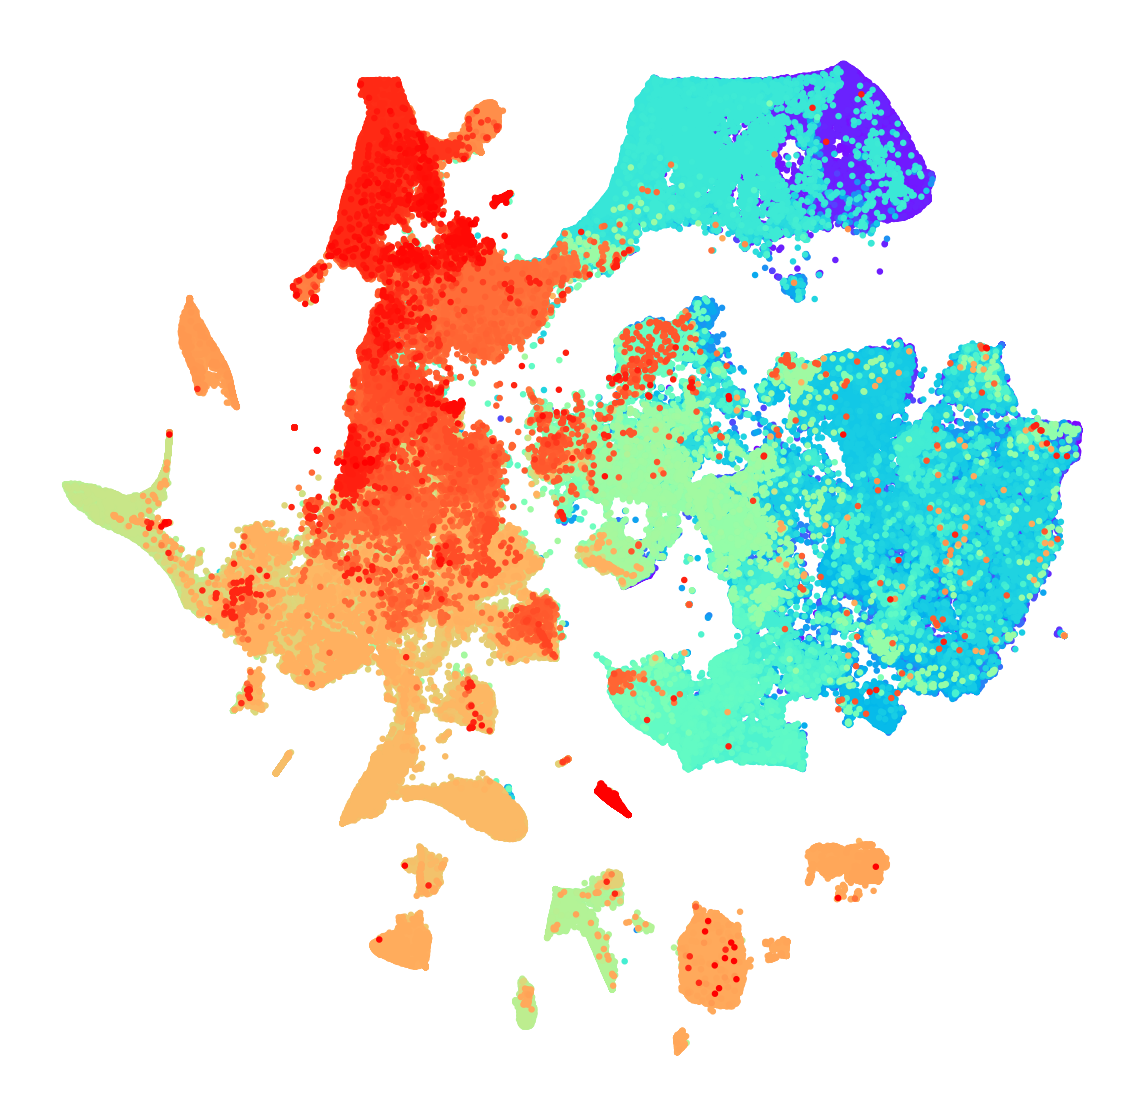

In [6]:
dev = db.mouse.Development
xy = dev[:].BTSNE
c = dev[:].Clusters
plt.figure(figsize=(10,10))
plt.scatter(xy[:,0], xy[:,1], c=dev[:].Clusters, cmap="rainbow", s=5)
plt.axis("off")

In [6]:
dev = db.mouse.Development
dev.genes = shoji.Dimension(shape=31053)

CPU times: user 60.9 ms, sys: 5.88 ms, total: 66.7 ms
Wall time: 82.7 ms


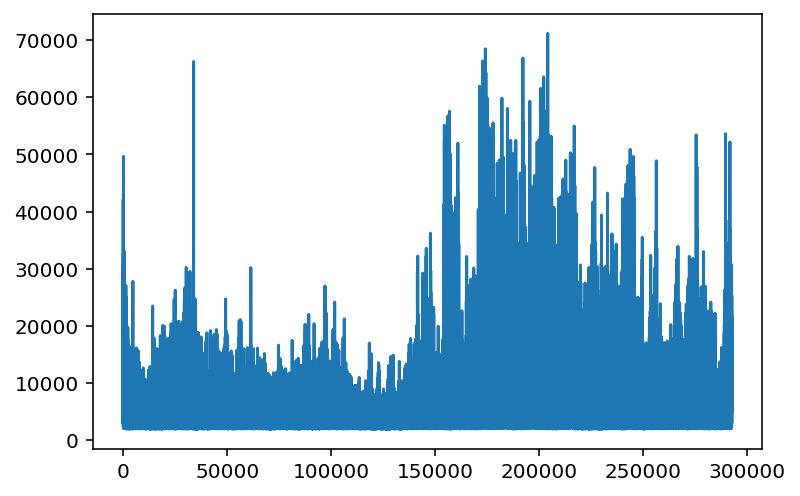

In [5]:
%%time
dev = db.mouse.Development
g=dev[:].TotalUMI
plt.plot(g)

In [23]:
%%time
dev[dev.cells[:8000]].Spliced
_

CPU times: user 876 ms, sys: 155 ms, total: 1.03 s
Wall time: 1.39 s


array([[ 2,  4, 17, ...,  1,  5,  0],
       [ 3,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint16)

In [24]:
%%time
fpool = "/Users/stelin/cytograph/20191003/data/dev_all.loom"
with loompy.connect(fpool, validate=True) as ds:
    print(ds["spliced"][:, :8000])

[[ 2  4 17 ...  1  5  0]
 [ 3  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
CPU times: user 1.44 s, sys: 134 ms, total: 1.57 s
Wall time: 1.57 s


In [28]:
from rich.console import Console
from rich.table import Table

table = Table()

table.add_column("Object", justify="right")
table.add_column("Name", justify="left")
table.add_column("dtype", justify="right")
table.add_column("dims", justify="right")
table.add_column("shape", justify="right")

#db.mouse.Development.Test = shoji.Workspace()
for x in db.mouse.Development:
    if isinstance(x, shoji.WorkspaceManager):
        table.add_row("Workspace", x.name, "", "", "")
    if isinstance(x, shoji.Dimension):
        table.add_row("Dimension", x.name, "", '{:,}'.format(x.shape) if x.shape is not None else "None", '{:,}'.format(x.length))
    if isinstance(x, shoji.Tensor):
        table.add_row("Tensor", x.name, x.dtype, " ✕ ".join([str(s) for s in x.dims]), " ✕ ".join(['{:,}'.format(s) for s in x.shape]))


console = Console(record=True)
console.print(table)

AttributeError: 'WorkspaceManager' object has no attribute 'name'

In [23]:
class Test:
    def __init__(self, wsm):
        self.wsm = wsm

    def _repr_html_(self):
        self = self.wsm
        if len(self._path) == 0:
            s = f"<h4>(root Workspace)</h4>"
        else:
            s = f"<h4>{self._name} (Workspace)</h4>"
        
        subspaces = self._workspaces()
        if len(subspaces) > 0:
            s += f"<h5>Sub-workspaces</h5>"
            s += "<table><tr><th>Name</th><th>Contents</th></tr>"
            for wsname in subspaces:
                ws = self[wsname]
                s += "<tr>"
                n_subspaces = len(ws._workspaces())
                n_dimensions = len(ws._dimensions())
                n_tensors = len(ws._tensors())
                s += f"<td align='left'>{ws._name}</td><td>{n_subspaces} workspaces, {n_dimensions} dimensions, {n_tensors} tensors</td>"
                s += "</tr>"
            s += "</table>"
    
        dimensions = self._dimensions()
        if len(dimensions) > 0:
            s += f"<h5>Dimensions</h5>"
            s += "<table><tr><th>Name</th><th>shape</th><th>length</th></tr>"
            for dname in dimensions:
                dim = self[dname]
                s += "<tr>"
                s += f"<td align='left'>{dim.name}</td>"
                s += f"<td>{dim.shape:,}</td>" if dim.shape is not None else "<td>None</td>"
                s += f"<td>{dim.length:,}</td>"
                s += "</tr>"
            s += "</table>"

        tensors = self._tensors()
        if len(tensors) > 0:
            s += f"<h5>Tensors</h5>"
            s += "<table><tr><th>Name</th><th>dtype</th><th>dims</th><th>shape</th></tr>"
            for tname in tensors:
                t = self[tname]
                s += "<tr>"
                s += f"<td align='left'>{t.name}</td>"
                s += f"<td align='left'>{t.dtype}</td>"
                s += "<td>" + " ✕ ".join([str(s) for s in t.dims]) + "</td>"
                s += "<td>" + " ✕ ".join(['{:,}'.format(s) for s in t.shape]) + "</td>"
                s += "</tr>"
            s += "</table>"
        return s

Test(db.mouse.Development)

In [ ]:
db._su

In [ ]:
class IncrementalEnrichment
    def __init__(self):
        self.n_cells = 0
        self.total_UMIs = 0
        self.nnz = 0
    
    def add_cluster(self, x: np.ndarray):
        self.n_cells += len(x)
        self.total_UMIs += x.sum()
        self.nnz += np.count_nonzero(x)
    
    def enrichment(self, x: np.ndarray, exclusive: bool = False):
        """
        Calculate the enrichment score for the set of expression values
        
        Args:
            x          Vector of expression values (e.g. for a cluster)
            exclusive  If True, the given vector is part of the reference data and should be subtracted
        """
        n = x.shape[0]
        x_nnz = np.count_nonzero(x)
        f_nnz = x_nnz / n
        x_total = x.sum()
        x_mean = x_total / n

        if exclusive:  # The cells in x are part of the database, so they should be subtracted
            f_nnz_overall = (self.nnz - x_nnz) / (self.n_cells - n)
            means_overall = (self.total_UMIs - x_total) / (self.n_cells - n)
        else:
            f_nnz_overall = self.nnz / self.n_cells
            means_overall = self.total_UMIs / self.n_cells 

        return (f_nnz + 0.1) / (f_nnz_overall + 0.1) * (x_mean + 0.01) / (means_overall + 0.01)


In [ ]:
db.allRNA = shoji.Workspace()
ws = db.allRNA
ws.clusters = shoji.Dimension(None)
ws.genes = shoji.Dimension()